<a href="https://colab.research.google.com/github/manjaria007/FakeNewsDetection/blob/main/FakeNewsDetectionKmeansClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Description on Dataset

This Dataset consists of about 40,000 articles consisting of fake as well as real news. 

Aim is to train model so that it can correctly predict whether a given piece of news is real or fake and real 


The Fake and real news data is given into two separate datasets with each dataset consisting around 20,000 articles each

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt #  plotting and data visualization
import seaborn as sns # improve visuals
sns.set() # Set as default style

import string # python library
import re # regex library

from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short # Preprocesssing
from gensim.models import Word2Vec # Word2vec

from sklearn import cluster # Kmeans clustering
from sklearn import metrics # Metrics for evaluation
from sklearn.decomposition import PCA #PCA
from sklearn.manifold import TSNE #TSNE
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import keras
from keras_preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

# NLP Library
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import unicodedata
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
fake = pd.read_csv('/content/drive/My Drive/FakeNewsDetectionProject/Fake.csv')
true = pd.read_csv('/content/drive/My Drive/FakeNewsDetectionProject/True.csv')

The first issue as seen above is that the True data contains:

A reuters disclaimer that the article is a tweet

"The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS. The opinions expressed are his own. Reuters has not edited the statements or confirmed their accuracy. @realDonaldTrump"

City Name and then publisher at the start
WASHINGTON (Reuters)


so in the next block of code I remove this from the data

In [ ]:
# The following is a crude way to remove the @realDonaldTrump tweet disclaimer and State/Publisher at start of text

cleansed_data = []
for data in true.text:
    if "@realDonaldTrump : - " in data:
        cleansed_data.append(data.split("@realDonaldTrump : - ")[1])
    elif "(Reuters) -" in data:
        cleansed_data.append(data.split("(Reuters) - ")[1])
    else:
        cleansed_data.append(data)

true["text"] = cleansed_data
true.head(10)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...",The White House said on Friday it was set to k...,politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...",President Donald Trump said on Thursday he bel...,politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,While the Fake News loves to talk about my so-...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,"Together, we are MAKING AMERICA GREAT AGAIN! b...",politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,Alabama Secretary of State John Merrill said h...,politicsNews,"December 28, 2017"


In [ ]:
true.text[7]

'While the Fake News loves to talk about my so-called low approval rating, @foxandfriends just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage & Russia hoax! [0746 EST] - Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packages, making Amazon richer and the Post Office dumber and poorer? Should be charging MUCH MORE! [0804 EST] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR) '

Some of the text still contains various characters/words such as:

1. Links
2. Timestamps
3. Brackets
4. Numbers


So we will be removing all such characters from the real and fake data using genlib preprocessing and a custom regex for the links in preperation for the Word2Vec

Before that however, the title and text will be merged in to one so that it can all be preprocessed together. I will also add a label for real and fake which will be used later to evaluate our clustering

In [ ]:
#Merging title and texts
fake['Sentences'] = fake['title'] + ' ' + fake['text']
true['Sentences'] = true['title'] + ' ' + true['text']

# Adding fake and true label
fake['Label'] = 0
true['Label'] = 1

# We can merge both together since we now have labels
final_data = pd.concat([fake, true])

# Randomize the rows so its all mixed up
final_data = final_data.sample(frac=1).reset_index(drop=True)

# Drop columns not needed
final_data = final_data.drop(['title', 'text', 'subject', 'date'], axis = 1)

final_data.head(10)

,Sentences,Label
0,South Africa's ANC votes to elect leader to re...,1
1,China urges Thailand to find Muslim Uighurs qu...,1
2,TRUMP POISED TO REVERSE OBAMA’S Politicized “G...,0
3,Senate kills family-planning rule; Pence break...,1
4,Trump Won This Typically Republican Demograph...,0
5,5 Ways Trump’s Mike Pence Introduction Was A ...,0
6,"Lawmakers to go to Cuba with Obama, who mulls ...",1
7,American McCarthyism: Neocon Warhawks’ Plan to...,0
8,Trump meets Irish PM at White House ahead of S...,1
9,Lying Liar Reince Priebus Says Trump Is Fulfi...,0


In [ ]:
#Here we preprocess the sentences
def remove_URL(s):
    regex = re.compile(r'https?://\S+|www\.\S+|bit\.ly\S+')
    return regex.sub(r'',s)

# Preprocessing functions to remove lowercase, links, whitespace, tags, numbers, punctuation, strip words
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, remove_URL, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short]

# Here we store the processed sentences and their label
processed_data = []
processed_labels = []

for index, row in final_data.iterrows():
    words_broken_up = preprocess_string(row['Sentences'], CUSTOM_FILTERS)
    # This eliminates any fields that may be blank after preprocessing
    if len(words_broken_up) > 0:
        processed_data.append(words_broken_up)
        processed_labels.append(row['Label'])

# Word2vec

In [ ]:
# Word2Vec model trained on processed data
model = Word2Vec(processed_data, min_count=1)


In [ ]:
model.wv.most_similar("country")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('nation', 0.8175091743469238),
 ('america', 0.6578010320663452),
 ('countries', 0.5856249332427979),
 ('europe', 0.5677709579467773),
 ('world', 0.5221788883209229),
 ('planet', 0.5170276761054993),
 ('path', 0.48782965540885925),
 ('marianorajoy', 0.4856421947479248),
 ('especially', 0.4822225272655487),
 ('dealmaker”', 0.4799584746360779)]

# Sentence Vectors

In [ ]:
# Getting the vector of a sentence based on average of all the word vectors in the sentence
# We get the average as this accounts for different sentence lengths

def ReturnVector(x):
    try:
        return model[x]
    except:
        return np.zeros(100)
    
def Sentence_Vector(sentence):
    word_vectors = list(map(lambda x: ReturnVector(x), sentence))
    return np.average(word_vectors, axis=0).tolist()

X = []
for data_x in processed_data:
    X.append(Sentence_Vector(data_x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
X_np = np.array(X)
X_np.shape


(44889, 100)

# Clustering

In [ ]:
# Training for 2 clusters (Fake and Real)
kmeans = cluster.KMeans(n_clusters=2, verbose=1)

# Fit predict will return labels
clustered = kmeans.fit_predict(X_np)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 476265.0939648131
start iteration
done sorting
end inner loop
Iteration 1, inertia 447635.28937978065
start iteration
done sorting
end inner loop
Iteration 2, inertia 444812.8807106936
start iteration
done sorting
end inner loop
Iteration 3, inertia 443993.65705134114
start iteration
done sorting
end inner loop
Iteration 4, inertia 443744.12244494795
start iteration
done sorting
end inner loop
Iteration 5, inertia 443660.4849577255
start iteration
done sorting
end inner loop
Iteration 6, inertia 443628.9461396466
start iteration
done sorting
end inner loop
Iteration 7, inertia 443620.7831406734
start iteration
done sorting
end inner loop
Iteration 8, inertia 443618.9437823136
start iteration
done sorting
end inner loop
Iteration 9, inertia 443618.56357260235
center shift 4.448732e-06 within tolerance 1.180388e-05
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inert

In [ ]:
testing_df = {'Sentence': processed_data, 'Labels': processed_labels, 'Prediction': clustered}
testing_df = pd.DataFrame(data=testing_df)

testing_df.head(10)


,Sentence,Labels,Prediction
0,"[south, africa, anc, votes, elect, leader, rep...",1,0
1,"[china, urges, thailand, muslim, uighurs, quic...",1,0
2,"[trump, poised, reverse, obama’s, politicized,...",0,0
3,"[senate, kills, family, planning, rule, pence,...",1,0
4,"[trump, won, typically, republican, demographi...",0,1
5,"[ways, trump’s, mike, pence, introduction, com...",0,1
6,"[lawmakers, cuba, obama, mulls, trade, moves, ...",1,0
7,"[american, mccarthyism, neocon, warhawks’, pla...",0,1
8,"[trump, meets, irish, white, house, ahead, pat...",1,0
9,"[lying, liar, reince, priebus, says, trump, fu...",0,1


The Results above show that it correctly clustered them in some cases where 0 is fake news and 1 is real news

In [ ]:
correct = 0
incorrect = 0
for index, row in testing_df.iterrows():
  if row['Labels'] == row['Prediction']:
    correct += 1
  else:
    incorrect += 1

print("Correctly clustered news:" + str((correct*100)/(correct+incorrect))+ "%")

Correctly clustered news:12.620018267281516%


# Visualization

In [ ]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X_np)

PCA_df = pd.DataFrame(pca_results)
PCA_df['cluster'] = clustered
PCA_df.columns = ['x1', 'x2', 'cluster']

In [ ]:
#T-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(pca_results)

tsne_df = pd.DataFrame(tsne_result)
tsne_df['cluster'] = clustered
tsne_df.columns = ['x1', 'x2', 'cluster']

Text(0.5, 1.0, 'visualized on pca')

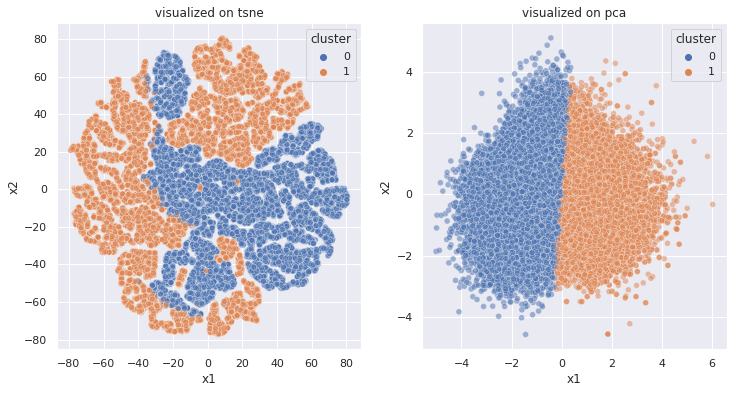

In [ ]:
#plots
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=PCA_df, x='x1', y='x2', hue='cluster', legend="full", alpha=0.5, ax=ax[1])
sns.scatterplot(data=tsne_df, x='x1', y='x2', hue='cluster', legend="full", alpha=0.5, ax=ax[0])
ax[0].set_title('visualized on tsne')
ax[1].set_title('visualized on pca')

# Why Fake News ia a Problem?

Fake news refer to misinformation, disinformation or mal-information which is spread through word of mouth and traditional media and more recently through digital forms of communication such as edited videos, memes, unverified advertisements and social media propagated rumours. Fake news spread through social media has become a serious problem, with the potential of it resulting in mob violence, suicides etc as a result of misinformation circulated on social media

#NLP using GloVe Embeddings

In [ ]:
true['category'] = 1
fake['category'] = 0

In [ ]:
df = pd.concat([true,fake])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


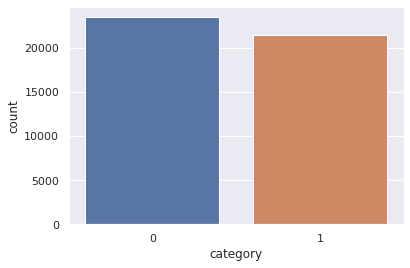

In [ ]:
sns.set_style("darkgrid")
sns.countplot(df.category)

# Dataset seems balanced

In [ ]:
df.isna().sum()

title        0
text         0
subject      0
date         0
Sentences    0
Label        0
category     0
dtype: int64

In [ ]:
df.title.count()

44898

In [ ]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

#Merging all the Text Data into 1column i.e. 'Text'

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

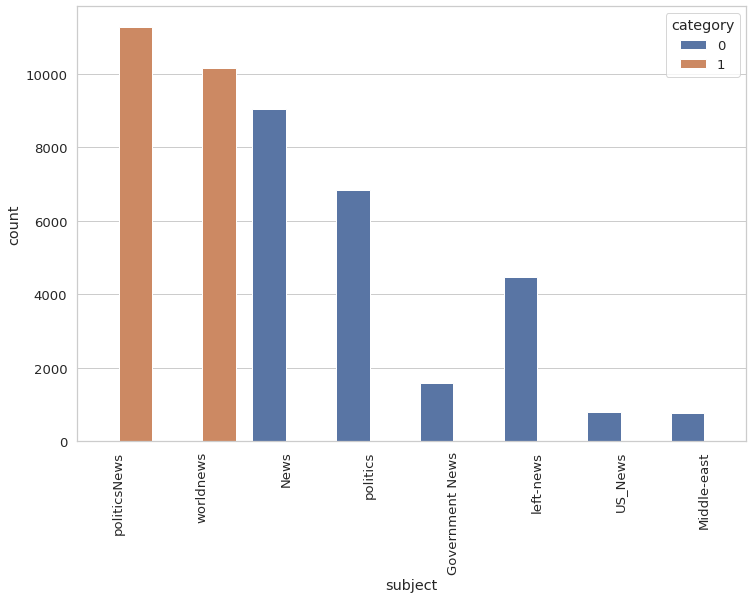

In [ ]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

#Topics in subject Column are different for both categories, Hence we have to exclude if from final text colum

In [ ]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

#What are stopwords?
Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. 

For instance, words like - the, he, have, etc. such words

In [ ]:
swords = set(stopwords.words('english'))
punctuation = list(string.punctuation)
swords.update(punctuation)

# Data Cleaning

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in swords:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

#Apply function on review column
df['text'] = df['text'].apply(denoise_text)

# Wordcloud for True News

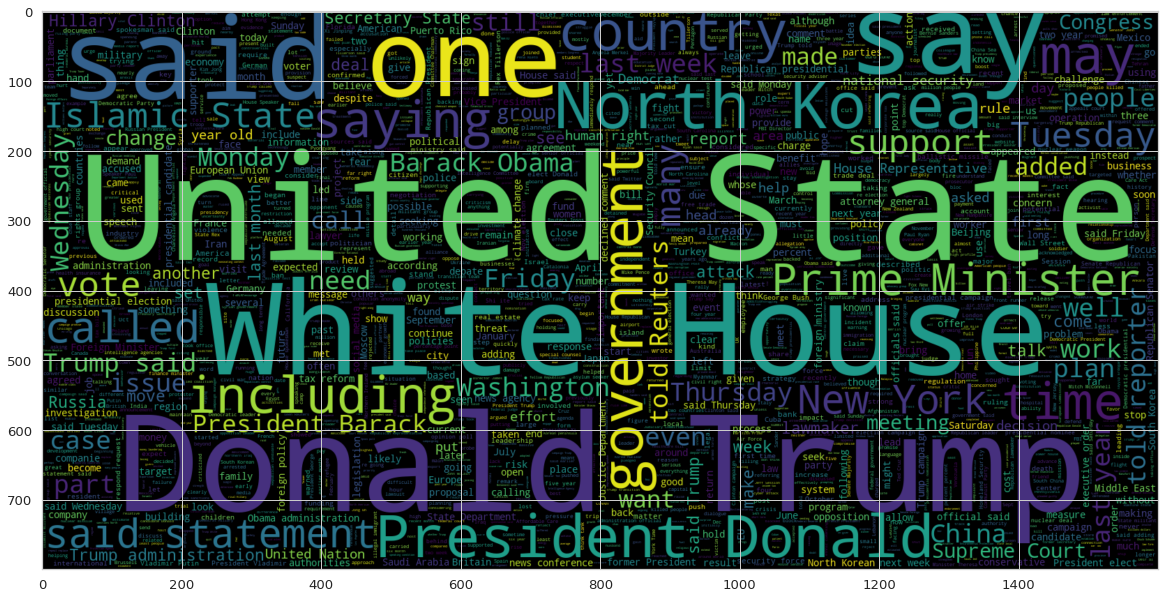

In [ ]:
plt.figure(figsize=(20,20)) #Text that is not Fake
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc, interpolation= 'bilinear')

# Wordcloud for Fake Text

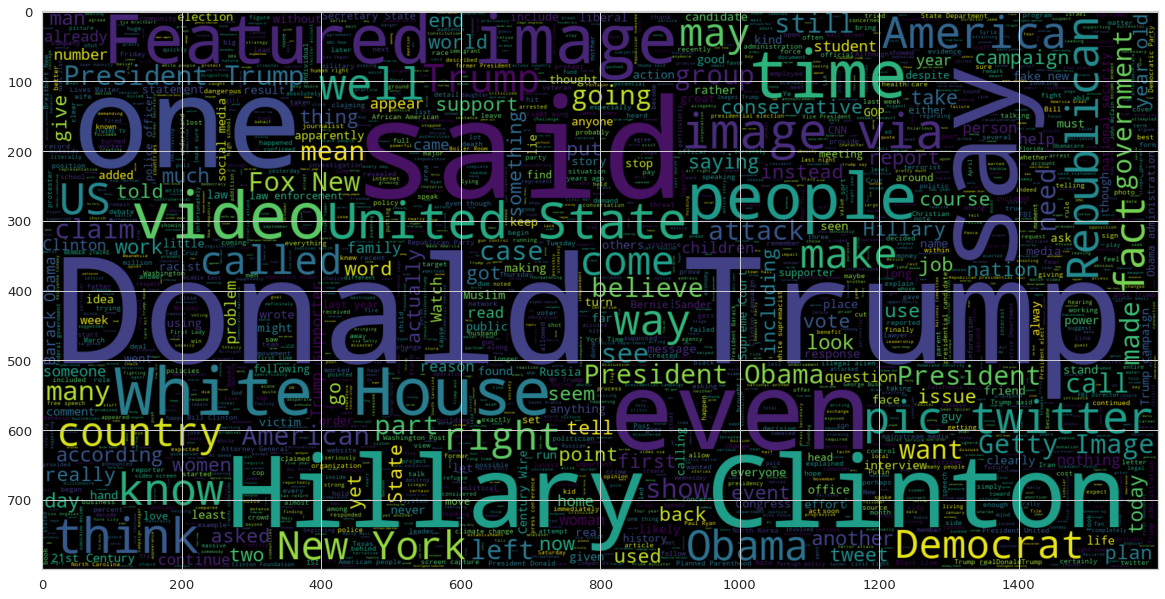

In [ ]:
plt.figure(figsize=(20,20)) #Text that is Fake
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc, interpolation='bilinear')

#Number of character in texts

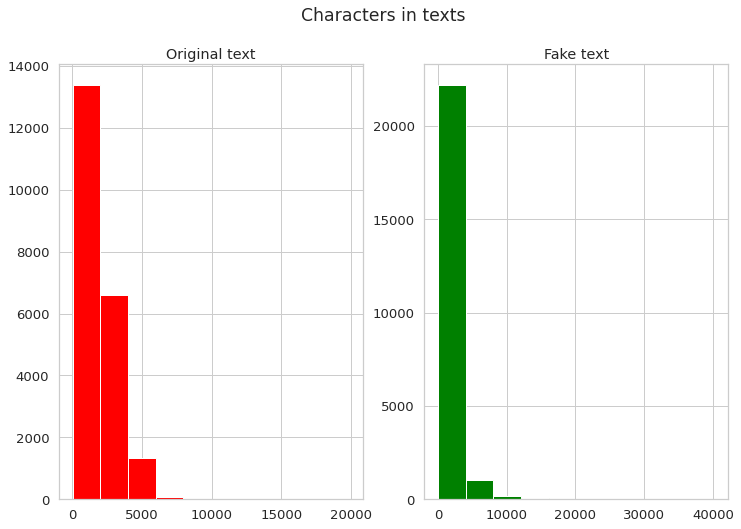

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
text_len = df[df['category']==1]['text'].str.len()
ax1.hist(text_len, color='red')
ax1.set_title('Original text')
text_len = df[df['category']==0]['text'].str.len()
ax2.hist(text_len, color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

Distribution for both is different. 2500 characters in text is the most common in true text category while around 5000 characters are most common in fake text category

#Number of words in each text

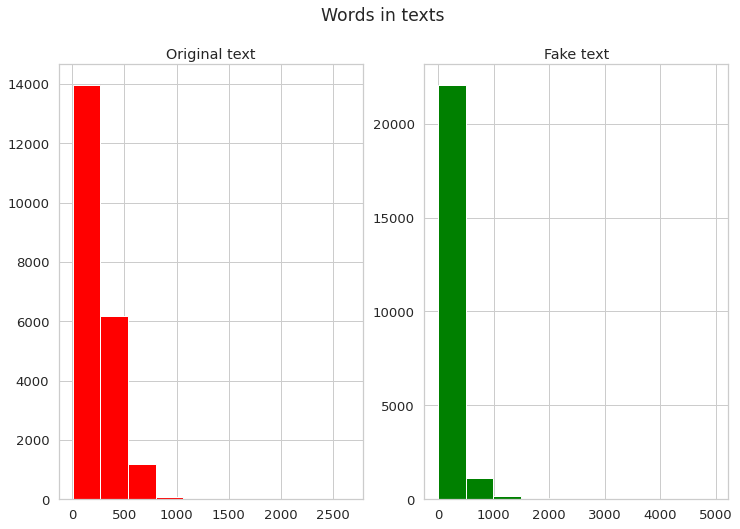

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

# Average Word length in a text

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each text')

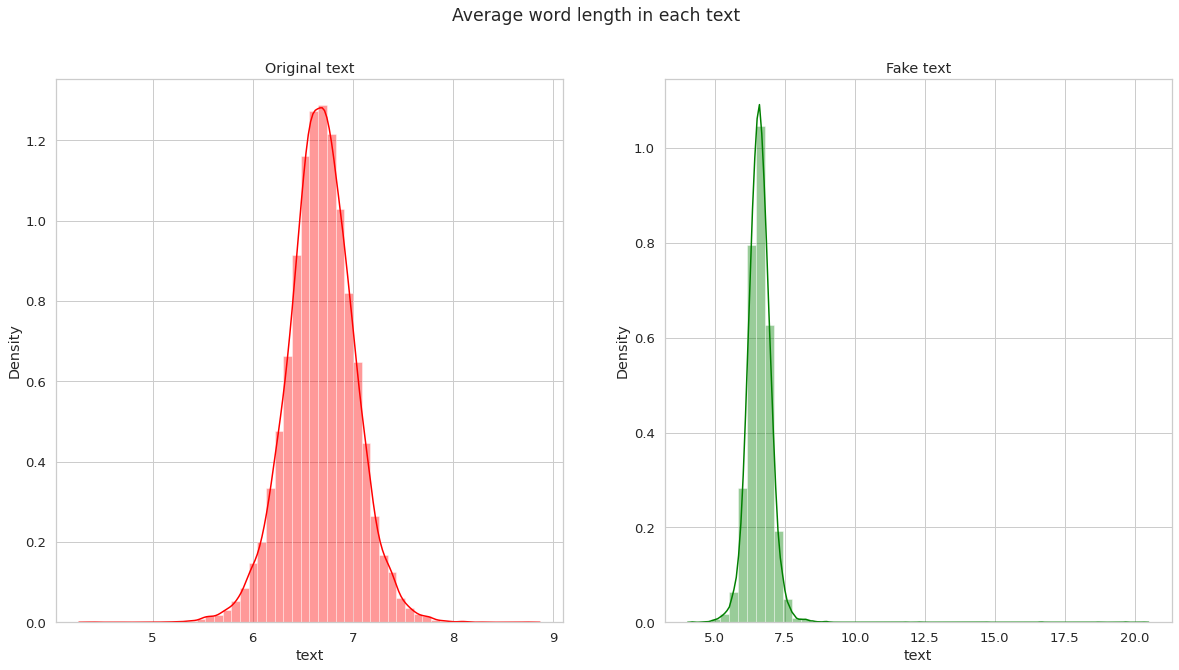

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['head', 'conservative', 'Republican', 'faction', 'U.S.']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Donald': 27708,
 'President': 33093,
 'Trump': 111495,
 'U.S.': 50343,
 'also': 30325,
 'one': 29369,
 'people': 33110,
 'said': 93159,
 'said.': 26194,
 'would': 54611}

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
  vec = CountVectorizer(ngram_range = (g, g)).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key= lambda x: x[1], reverse=True)
  return words_freq[:n]

# Unigram Analysis

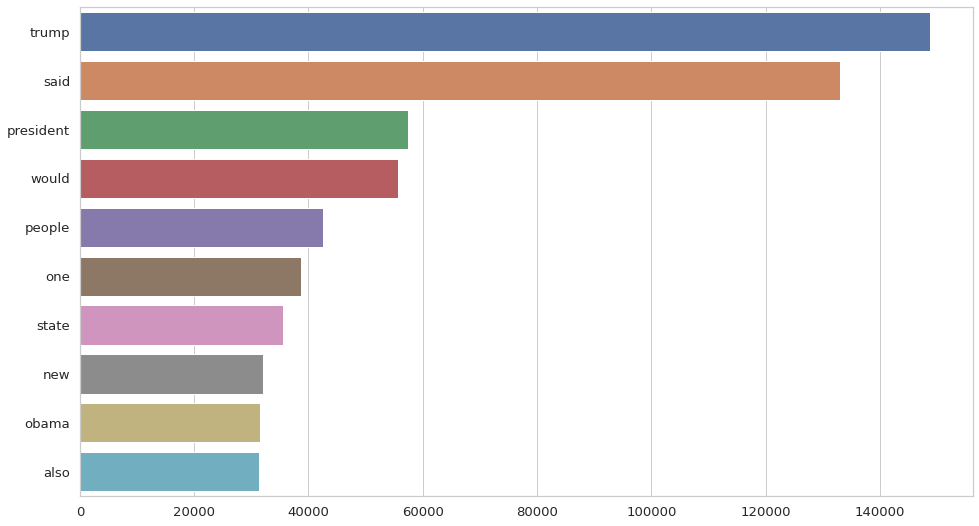

In [ ]:
plt.figure(figsize=(16,9))
most_common_uni = get_top_text_ngrams(df.text, 10, 1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()), y=list(most_common_uni.keys()))

# Bigram Analysis

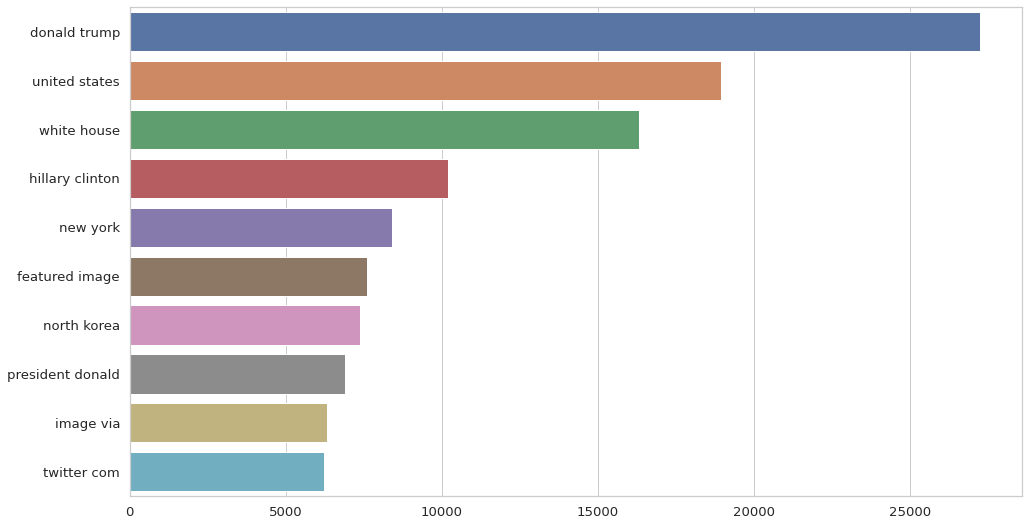

In [ ]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

# Trigram Analysis

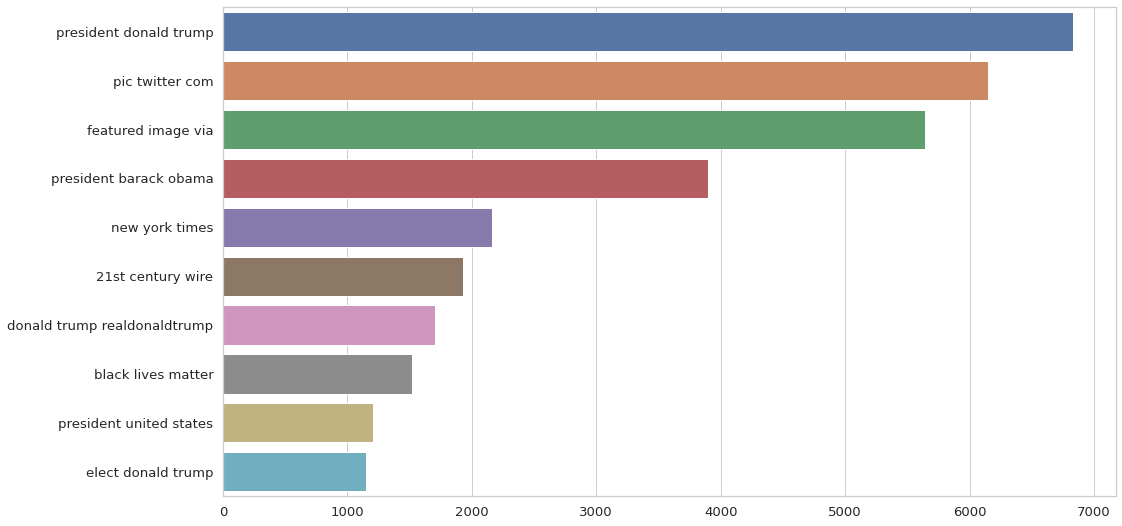

In [ ]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

# train and test

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [ ]:
max_features = 10000
maxlen = 300

* **Tokenizing Text** -> Repsesenting each word by a number

* Mapping of orginal word to number is preserved in word_index property of tokenizer

* Tokenized applies basic processing like changing it to lower case, explicitely setting that as False

Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

References:

GloVe - 
https://nlp.stanford.edu/projects/glove/

https://deeplearning.lipingyang.org/wp-content/uploads/2017/12/How-is-GloVe-different-from-word2vec_-Quora.pdf

**Introduction**: GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.


It is built on an important idea, you can derive semantic relationship between words from the co-occurence matrix. Given a corpus having V words, the co-occurence matrix X will be a V * V matrix, where the ith row and jth row of X, X_ij denotes how many times would i has co-occured with word j. An example co-occurence matrix might look as follows.

For reference:
https://medium.com/@jonathan_hui/nlp-word-embedding-glove-5e7f523999f6

https://medium.com/@jonathan_hui/nlp-bert-transformer-7f0ac397f524

**Co-Occurence Matrix**: The co-occurrence matrix for the sentence “the cat sat on the mat” with a window size of 1. As you probably noticed it is a symmetric matrix. How do we get a metric that measures semantic similarity between words from this? For that, you will need three words at a time. Let me concretely lay down this statement.

The behavior of P_ik/P_jk for various words Consider the entity P_ik/P_jk where P_ik = X_ik/X_i Here P_ik denotes the probability of seeing word i and k together, which is computed by dividing the number of times i and k appeared together (X_ik) by the total number of times word i appeared in the corpus (X_i). You can see that given two words, i.e. ice and steam, if the third word k (also called the “probe word”), is very similar to ice but irrelevant to steam (e.g. k=solid), P_ik/P_jk will be very high (>1), is very similar to steam but irrelevant to ice (e.g. k=gas), P_ik/P_jk will be very small (<1), is related or unrelated to either words, then P_ik/P_jk will be close to 1 So, if we can find a way to incorporate P_ik/P_jk to computing word vectors we will be achieving the goal of using global statistics when learning word vectors.

Source Credits - https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010



Word2Vec vs GloVe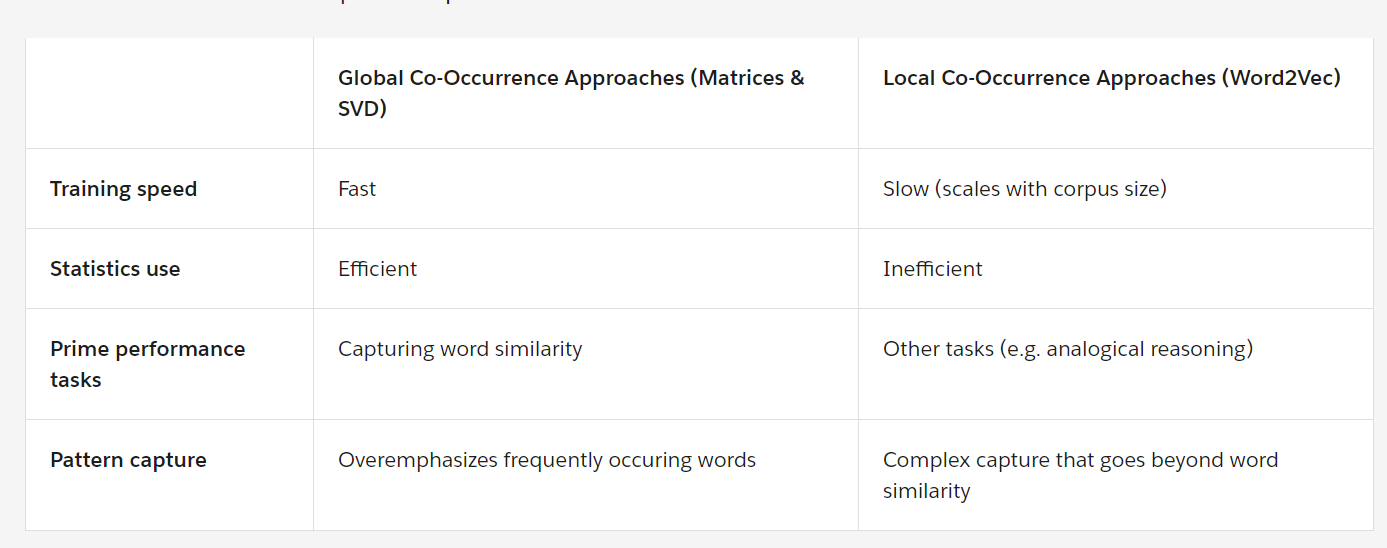

#Co Occurence Matrix Example

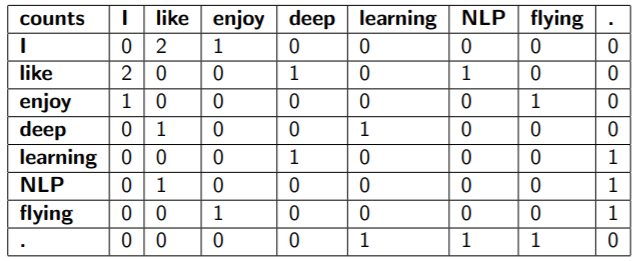

In [ ]:
#Data: https://www.kaggle.com/icw123/glove-twitter

EMBEDDING_FILE = '/content/drive/My Drive/GloVe_twitterData/glove.twitter.27B.100d.txt'

In [ ]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


#Some Model parameters

In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.00001)

#Training The Model

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embedding layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))

#LSTM
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout = 0.25, dropout = 0.25))
model.add(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 300, 128)          117248    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size, validation_data = (X_test, y_test),
                    epochs = epochs, callbacks = [learning_rate_reduction])

Epoch 1/10
132/132 [==============================] - 279s 2s/step - loss: 0.1799 - accuracy: 0.9220 - val_loss: 0.0455 - val_accuracy: 0.9868
Epoch 2/10
132/132 [==============================] - 278s 2s/step - loss: 0.0317 - accuracy: 0.9894 - val_loss: 0.0230 - val_accuracy: 0.9912
Epoch 3/10
132/132 [==============================] - 277s 2s/step - loss: 0.0193 - accuracy: 0.9931 - val_loss: 0.0148 - val_accuracy: 0.9962
Epoch 4/10
132/132 [==============================] - 274s 2s/step - loss: 0.0157 - accuracy: 0.9947 - val_loss: 0.0147 - val_accuracy: 0.9953
Epoch 5/10
132/132 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 0.9969
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
132/132 [==============================] - 274s 2s/step - loss: 0.0099 - accuracy: 0.9969 - val_loss: 0.0288 - val_accuracy: 0.9931
Epoch 6/10
132/132 [==============================] - 274s 2s/step - loss: 0.0068 - accuracy: 0.9977 - val_loss: 0.0088 -

#Analysis After Training the model

In [ ]:
print("Accuracy of the model on Training Data is-", model.evaluate(x_train, y_train)[1]*100, "%")
print("Accuracy of the model on Testing Data is-", model.evaluate(X_test, y_test)[1]*100, "%")

1053/1053 [==============================] - 157s 149ms/step - loss: 1.4460e-04 - accuracy: 1.0000
Accuracy of the model on Training Data is- 99.99703168869019 %
351/351 [==============================] - 53s 150ms/step - loss: 0.0113 - accuracy: 0.9972
Accuracy of the model on Testing Data is- 99.7238278388977 %


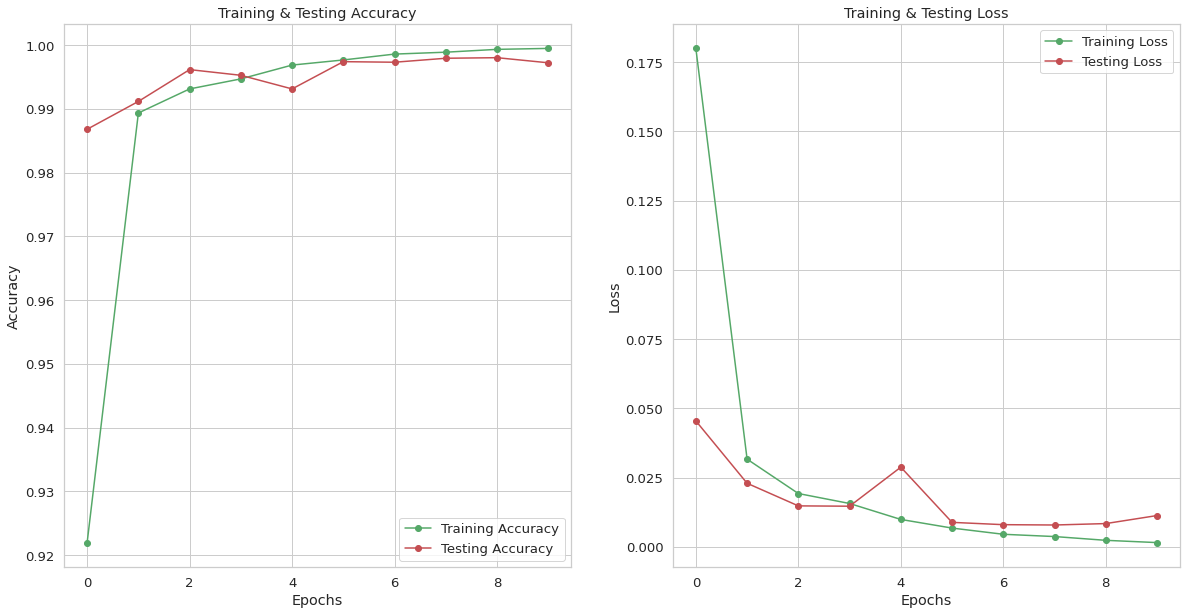

In [ ]:
epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred = model.predict_classes(X_test)
pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [1]], dtype=int32)

In [ ]:
print(classification_report(y_test, pred, target_names=['Fake', 'Not Fake']))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5858
    Not Fake       1.00      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [ ]:
cm = confusion_matrix(y_test, pred)
cm

array([[5851,    7],
       [  24, 5343]])

In [ ]:
cm = pd.DataFrame(cm, index = ['Fake', 'Original'], columns = ['Fake', 'Original'])

Text(63.5, 0.5, 'Actual')

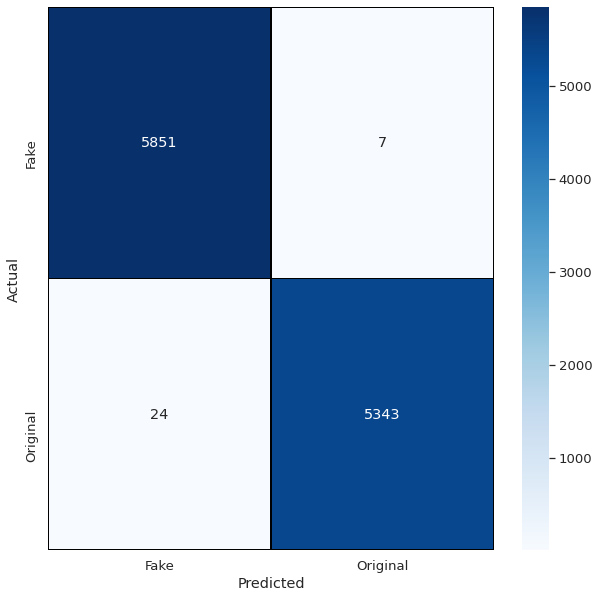

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=['Fake', 'Original'],
            yticklabels=['Fake', 'Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")